<a href="https://colab.research.google.com/github/ldejuan/covid/blob/master/descriptive_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import zipfile

In [0]:
#read zip train and test data set from zip Archive
PATH_DATA= "./drive/My Drive/covid/"
fileNameZip = 'covid19-global-forecasting-week-1.zip'
archiveName = "%s%s"%(PATH_DATA,fileNameZip)
trainName= 'train.csv'
testName = 'test.csv'
submissionNane = 'submission.csv'
if zipfile.is_zipfile(archiveName):
  with zipfile.ZipFile(archiveName) as archive:
    dfTrain = pd.read_csv(archive.open(trainName,'r')).\
      rename(columns={"Country/Region":"Country_Region",
                      "Province/State":"Province_State"})
      
    dfTest  = pd.read_csv(archive.open(testName,'r')).\
      rename(columns={"Country/Region":"Country_Region",
                      "Province/State":"Province_State"})
    dfSoubmission  = pd.read_csv(archive.open(submissionNane,'r'))
  

In [0]:
#Basic transformations
dfTrain['Date'] = pd.to_datetime(dfTrain['Date'])

In [4]:
dfTest.head()

,ForecastId,Province_State,Country_Region,Lat,Long,Date
0,1,NaN,Afghanistan,33.0,65.0,2020-03-12
1,2,NaN,Afghanistan,33.0,65.0,2020-03-13
2,3,NaN,Afghanistan,33.0,65.0,2020-03-14
3,4,NaN,Afghanistan,33.0,65.0,2020-03-15
4,5,NaN,Afghanistan,33.0,65.0,2020-03-16


In [5]:
dfSoubmission.head()

,ForecastId,ConfirmedCases,Fatalities
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,1
4,5,1,1


In [6]:
# Recover the number of dates per Province_State
dfTrain[['Country_Region','Province_State','Date','Fatalities']]\
  .groupby(['Country_Region','Province_State']).agg(['min','max','count'])

Date             ... Fatalities      
                                                   min        max  ...        max count
Country_Region Province_State                                      ...                 
Australia      Australian Capital Territory 2020-01-22 2020-03-18  ...        0.0    57
               From Diamond Princess        2020-01-22 2020-03-18  ...        0.0    57
               New South Wales              2020-01-22 2020-03-18  ...        5.0    57
               Northern Territory           2020-01-22 2020-03-18  ...        0.0    57
               Queensland                   2020-01-22 2020-03-18  ...        0.0    57
...                                                ...        ...  ...        ...   ...
United Kingdom Cayman Islands               2020-01-22 2020-03-18  ...        1.0    57
               Channel Islands              2020-01-22 2020-03-18  ...        0.0    57
               Gibraltar                    2020-01-22 2020-03-18  ...        0.0    57
               Montserrat                   2020-01-22 2020-03-18  ...        0.0    57
               United Kingdom               2020-01-22 2020-03-18  ...       71.0    57

[130 rows x 6 columns]

In [0]:
#Create a new columns with the sum of Fatalities and ConfirmedCases by Country_Region

dfCountryAgg = dfTrain[["Country_Region","Date","Fatalities","ConfirmedCases"]]\
  .groupby(["Country_Region","Date"]).transform(lambda x: np.sum(x))\
  .rename(columns = {'Fatalities':'Country_Fatalities', 'ConfirmedCases':'Country_ConfirmedCases'})

dfTrain = dfTrain.merge(dfCountryAgg, left_index=True,right_index=True)



In [0]:
def aggByCountry(x):
  x['Country_Fatalities'] = np.sum(x.Fatalities)
  x['Country_ConfirmedCases'] = np.sum(x.ConfirmedCases)
  return x
dfTrainAgg = dfTrain.groupby(["Country_Region","Date"]).apply(aggByCountry)

In [44]:
dfTrainAgg.head()

,Id,Province_State,Country_Region,Lat,Long,Date,ConfirmedCases,Fatalities,Country_Fatalities,Country_ConfirmedCases
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0,0.0,0.0


In [0]:
#Study only at country level
dfCountry = dfTrainAgg[["Country_Region","Date","Country_Fatalities","Country_ConfirmedCases"]]\
  .groupby(["Country_Region","Date"]).agg(lambda x: x[0])\
  .reset_index()\
  .rename(columns = {'Country_Fatalities' : 'Fatalities', 'Country_ConfirmedCases' : 'ConfirmedCases'})

In [46]:
dfCountry.head()

,Country_Region,Date,Fatalities,ConfirmedCases
0,Afghanistan,2020-01-22,0.0,0.0
1,Afghanistan,2020-01-23,0.0,0.0
2,Afghanistan,2020-01-24,0.0,0.0
3,Afghanistan,2020-01-25,0.0,0.0
4,Afghanistan,2020-01-26,0.0,0.0


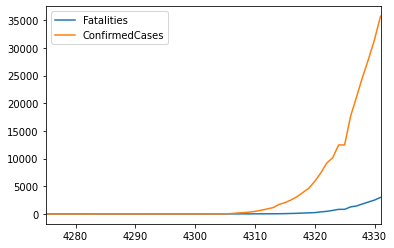

In [49]:
#Some Graph per Country/Region
selectedCountry = 'Italy'
dfSelectedCountry = dfCountry.query("Country_Region == @selectedCountry")
dfSelectedCountry[['Fatalities','ConfirmedCases']].plot()

In [35]:
# Some testing to ensure that the country_confirmedCase fatalities is well computed
dateMax=dfSelectedCountry['Date'].max()
dfSelectedCountry.query('Date == @dateMax').head()

,Country_Region,Date,Country_Fatalities,Country_CondfirmedCases
8834,US,2020-03-18,118.0,7786.0


In [0]:
#Find a date offset for each country on Fatalities Rate
FatalitiesLevel = 5
dfSelectedCountry[dfSelectedCountry["Fatalities"]>=FatalitiesLevel]['Date'].min()


In [0]:
#Analyze only countries with fatalities > SelectedFatalities
FatalitiesLevel = 1
def selectDeathDate(x):
  firstDate=x[x.Fatalities>=FatalitiesLevel].Date.min()
  x['firstDate'] = firstDate
  x['Fatality_Period'] = (x.Date - firstDate) / np.timedelta64(1, 'D')
  return x
dfCountryNoZero = dfCountry.groupby(["Country_Region"])\
  .apply(selectDeathDate)\
  .dropna()
dfCountryNoZero = dfCountryNoZero[dfCountryNoZero.Fatality_Period >=0]

In [53]:
dfCountryNoZero.head()

,Country_Region,Date,Fatalities,ConfirmedCases,firstDate,Fatality_Period
106,Albania,2020-03-11,1.0,12.0,2020-03-11,0.0
107,Albania,2020-03-12,1.0,23.0,2020-03-11,1.0
108,Albania,2020-03-13,1.0,33.0,2020-03-11,2.0
109,Albania,2020-03-14,1.0,38.0,2020-03-11,3.0
110,Albania,2020-03-15,1.0,42.0,2020-03-11,4.0


In [64]:
dfOneCountry = dfCountryNoZero.query("Country_Region == 'China'")
dfOneCountry.head()
#np.diff(dfOneCountry.Fatalities,prepend = 0)

,Country_Region,Date,Fatalities,ConfirmedCases,firstDate,Fatality_Period
1653,China,2020-01-22,17.0,548.0,2020-01-22,0.0
1654,China,2020-01-23,18.0,643.0,2020-01-22,1.0
1655,China,2020-01-24,26.0,920.0,2020-01-22,2.0
1656,China,2020-01-25,42.0,1406.0,2020-01-22,3.0
1657,China,2020-01-26,56.0,2075.0,2020-01-22,4.0


In [0]:
#Calculated the Daily Rate of Fatalities and ConfirmedCases at country level
def calculateRate(x):
  x['Fatalities_Rate'] = np.diff(x.Fatalities, prepend = np.NaN)/x.Fatalities
  x['ConfirmedCases_Rate'] = np.diff(x.ConfirmedCases, prepend = np.NaN)/x.ConfirmedCases
  return x
dfCountryRate = dfCountryNoZero.groupby(["Country_Region"])\
  .apply(calculateRate)\
  .dropna()

In [113]:
#Add features
dfCountryRate['Fatalities_Log'] = np.log(dfCountry.Fatalities)
dfCountryRate['ConfirmedCases_Log'] = np.log(dfCountry.ConfirmedCases)
dfCountryRate['Period_2'] = dfCountryRate.Fatality_Period**2

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [122]:
dfCountryRate[dfCountry.Fatalities < 1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Country_Region,Date,Fatalities,ConfirmedCases,firstDate,Fatality_Period,Fatalities_Rate,ConfirmedCases_Rate,Fatalities_Log,ConfirmedCases_Log,Period_2
3930,Iceland,2020-03-16,0.0,180.0,2020-03-15,1.0,-inf,0.05,-inf,5.192957,1.0


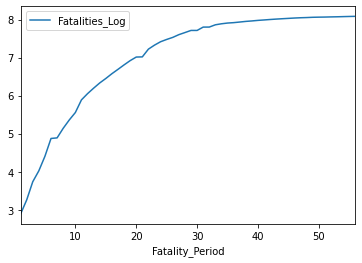

In [112]:
dfCountryRate.query("Country_Region == 'China'")[['Fatality_Period','Fatalities_Log']].plot(x='Fatality_Period',y='Fatalities_Log')

In [109]:
dfCountryRate.head()

,Country_Region,Date,Fatalities,ConfirmedCases,firstDate,Fatality_Period,Fatalities_Rate,ConfirmedCases_Rate,Fatalities_Log,ConfirmedCases_Log
107,Albania,2020-03-12,1.0,23.0,2020-03-11,1.0,0.0,0.478261,0.0,3.135494
108,Albania,2020-03-13,1.0,33.0,2020-03-11,2.0,0.0,0.303030,0.0,3.496508
109,Albania,2020-03-14,1.0,38.0,2020-03-11,3.0,0.0,0.131579,0.0,3.637586
110,Albania,2020-03-15,1.0,42.0,2020-03-11,4.0,0.0,0.095238,0.0,3.737670
111,Albania,2020-03-16,1.0,51.0,2020-03-11,5.0,0.0,0.176471,0.0,3.931826
